---
date: last-modified
---

# TOLNet Plot Generation Tutorial Notebook

## Summary
This notebook demonstrates how to plot ozone mixing ratio data from multiple lidars in the Tropospheric Ozone Lidar Network (TOLNet) to visualize a stratospheric intrusion event that occurred in February 2022.

The notebook walks through these steps:

1) Data Import - Read TOLNet data from five network lidars
2) Data Standardization - Convert variables to consistent units across all lidars
3) Visualization - Create time/altitude plots showing ozone mixing ratios with color-coded values
4) Output - Save each plot as an image file

Each lidar has its own dedicated section for plot creation.


### Prerequisites

**Required libraries:**

- h5py
- matplotlib
- numpy
- pyhdf

**Setup Requirements:**

- Create both a "Files" and "Plots" folder in the same directory as this notebook
- **Download the required TOLNet data files before running the notebook**
- **Update file paths in the code to point to your downloaded data files**

### Notebook Author/Affiliation

Sean Leavor/Atmospheric Science Data Center (ASDC)


## Setup

In [1]:
from datetime import datetime, timedelta

import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pyhdf.SD import SD, SDC

## NASA LaRC

The TOLNet plots for LaRC are made from two different files, so we read both of them in and combine their data into one array for O3 mixing ratio, time, and altitude.

- Define the files and data types you want to read to integrate into your plot

In [2]:
file1 = "Files/NASA LaRC/TOLNet-O3_LMOL_20220218_R2.h5"
f1 = h5py.File(file1, "r")
data1 = f1["DATA"]

file2 = "Files/NASA LaRC/TOLNet-O3_LMOL_20220219_R2.h5"
f2 = h5py.File(file2, "r")
data2 = f2["DATA"]

- Read variables from the files, convert altitude to km
- Combine data from files into one array
- Set missing data to nan
- Give the time the correct timezone

In [ ]:
o3mr1 = np.array(data1["O3MR"])
time1 = np.array(data1["TIME_MID_UT_UNIX"]) / 1000.0
alt1 = np.array(data1["ALT"]) / 1000

o3mr2 = np.array(data2["O3MR"])
time2 = np.array(data2["TIME_MID_UT_UNIX"]) / 1000.0
alt2 = np.array(data2["ALT"]) / 1000

o3mr = np.hstack((o3mr1, o3mr2))
time = np.append(time1, time2)
alt = np.append(alt1, alt2)

wh = np.where(o3mr == -9999.0)
o3mr[wh] = np.nan

time = list(map(datetime.utcfromtimestamp, time))

- Define Min/Max values for the plot, tick values for the time axis
- Create the plot and colorbar

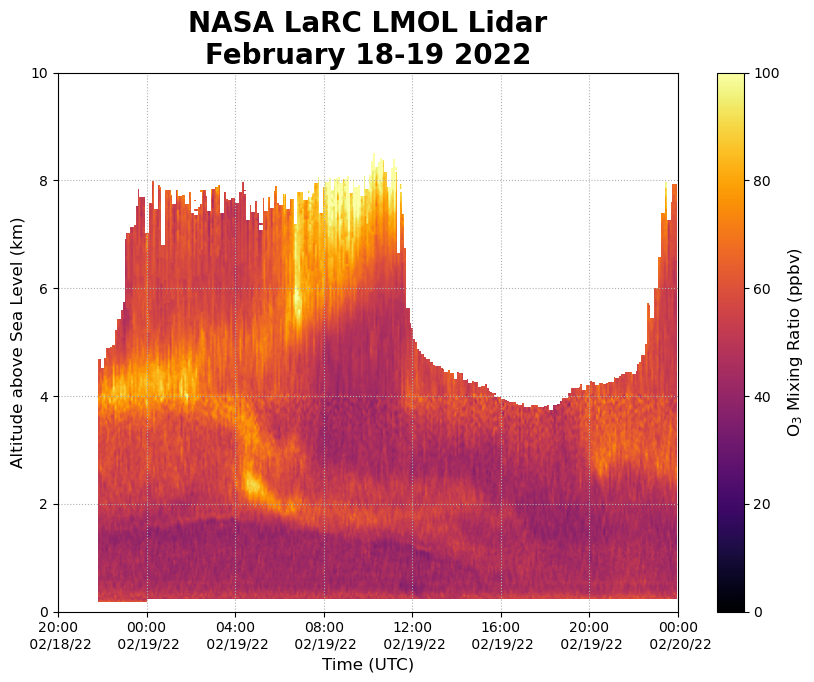

In [ ]:
time_min = mdates.date2num(np.min(time))
time_max = mdates.date2num(np.max(time))
alt_min = np.min(alt)
alt_max = np.max(alt)

time_ticks = [
    datetime(2022, 2, 18, 20),
    datetime(2022, 2, 19, 0),
    datetime(2022, 2, 19, 4),
    datetime(2022, 2, 19, 8),
    datetime(2022, 2, 19, 12),
    datetime(2022, 2, 19, 16),
    datetime(2022, 2, 19, 20),
    datetime(2022, 2, 20, 00),
]

fig, ax = plt.subplots(figsize=(10, 7), facecolor="white")

gsfc = ax.imshow(
    o3mr,
    vmin=0,
    vmax=100,
    aspect="auto",
    cmap="inferno",
    extent=(time_min, time_max, alt_max, alt_min),
)
ax.xaxis_date()
date_format = mdates.DateFormatter("%H:%M\n %D")
ax.xaxis.set_major_formatter(date_format)
ax.set(xlabel="Time (UTC)", ylabel="Altitude above Sea Level (km)", xticks=time_ticks)
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)

cbar = plt.colorbar(gsfc, ax=ax, label="O$_3$ Mixing Ratio (ppbv)")
cbar.set_label("O$_3$ Mixing Ratio (ppbv)", size=12)

plt.title("NASA LaRC LMOL Lidar\nFebruary 18-19 2022", fontweight="bold", fontsize="20")
plt.xlim([datetime(2022, 2, 18, 20), datetime(2022, 2, 20, 00)])
plt.ylim([0, 10])
plt.grid(linestyle=":")

plt.savefig("Plots/NASA-LaRC-Lidar_2022-02-18.png")
plt.show()

## University of Alabama, Huntsville

TOLNet hdf4 data is stored in a strange time format where you get the time by getting the year fraction by dividing by 365.25 and adding the decimal component of that to 2022

- You will need to adjust variables based on paths for which file you want to plot

In [5]:
file = "Files/UAH/groundbased_lidar.o3_uah001_hires_huntsville.al_20220218t182031z_20220219t085845z_001.hdf"
f = SD(file, SDC.READ)

- Read O3 mixing ratio, rotate it so it displays correctly when plotted, and convert from ppmv to ppbv
- Read altitude, convert to km
- Get year fraction from datetime variable, convert it into a useable date and correct timezone

In [ ]:
o3 = f.select("O3.MIXING.RATIO.VOLUME_DERIVED")
o3mr = np.rot90(o3[:, :] * 1000)
wh = np.where(o3mr < 0)
o3mr[wh] = np.nan

alt = f.select("ALTITUDE")
alt = alt[:] / 1000

time = f.select("DATETIME")
time = time[:]
yearfrac = (time / 365.25) % 1
newtime = np.array([])
for i in range(len(yearfrac)):
    newtime = np.append(
        newtime, datetime(2022, 1, 1) + timedelta(yearfrac[i] * 365.25) - timedelta(hours=12)
    )

- Define Min/Max values for the plot, tick values for the time axis
- Create the plot and colorbar

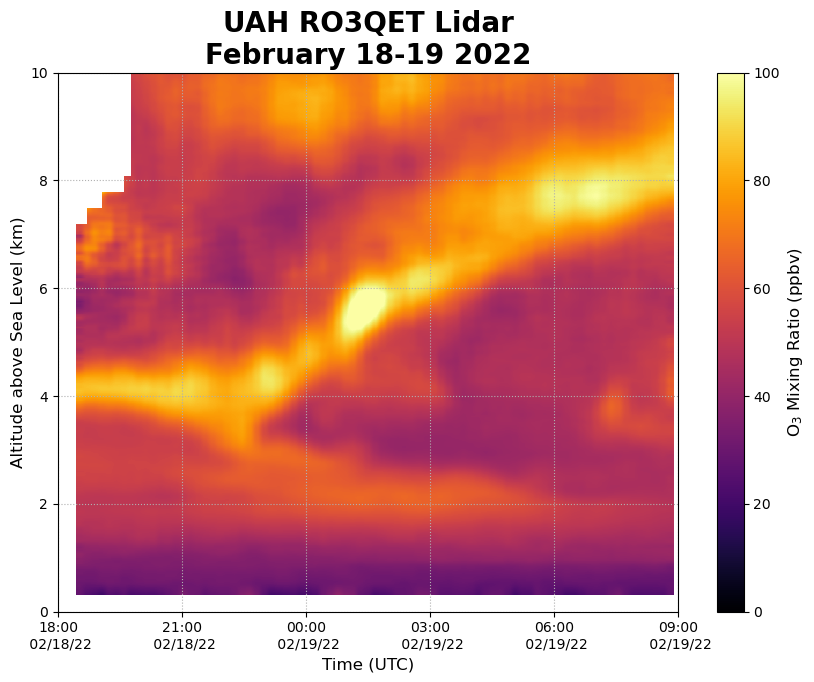

In [ ]:
time_min = mdates.date2num(np.min(newtime))
time_max = mdates.date2num(np.max(newtime))
alt_min = np.min(alt)
alt_max = np.max(alt)

time_ticks = [
    datetime(2022, 2, 18, 18),
    datetime(2022, 2, 18, 21),
    datetime(2022, 2, 19, 0),
    datetime(2022, 2, 19, 6),
    datetime(2022, 2, 19, 3),
    datetime(2022, 2, 19, 9),
]

fig, ax = plt.subplots(figsize=(10, 7), facecolor="white")

uah = ax.imshow(
    o3mr,
    vmin=0,
    vmax=100,
    aspect="auto",
    cmap="inferno",
    extent=(time_min, time_max, alt_min, alt_max),
)
ax.xaxis_date()
date_format = mdates.DateFormatter("%H:%M\n %D")
ax.xaxis.set_major_formatter(date_format)
ax.set(xlabel="Time (UTC)", ylabel="Altitude above Sea Level (km)", xticks=time_ticks)
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)

cbar = plt.colorbar(uah, ax=ax, label="O$_3$ Mixing Ratio (ppbv)")
cbar.set_label("O$_3$ Mixing Ratio (ppbv)", size=12)

plt.title("UAH RO3QET Lidar\nFebruary 18-19 2022", fontweight="bold", fontsize="20")
plt.xlim([datetime(2022, 2, 18, 18), datetime(2022, 2, 19, 9)])
plt.ylim([0, 10])
plt.grid(linestyle=":")

plt.savefig("Plots/UAH-Lidar_2022-02-18.png")
plt.show()

## NASA JPL

JPL measurements are just a function of altitude, not altitude and time, so they are not contour plots like the others.

- You will need to adjust variables based on paths for which file you want to plot

In [8]:
file = "Files/NASA JPL/groundbased_lidar.o3_nasa.jpl003_clim_table.mountain.ca_20220217t064845z_20220217t090447z_001.hdf"
f = SD(file, SDC.READ)

- Read O3 mixing ratio, rotate it so it displays correctly when plotted, and convert from ppmv to ppbv
- Read altitude, convert to km

In [ ]:
o3 = f.select("O3.MIXING.RATIO.VOLUME_DERIVED")
o3mr = o3[:] * 1000
wh = np.where(o3mr < 0)
o3mr[wh] = np.nan

alt = f.select("ALTITUDE")
alt = alt[:] / 1000

-Make the plot

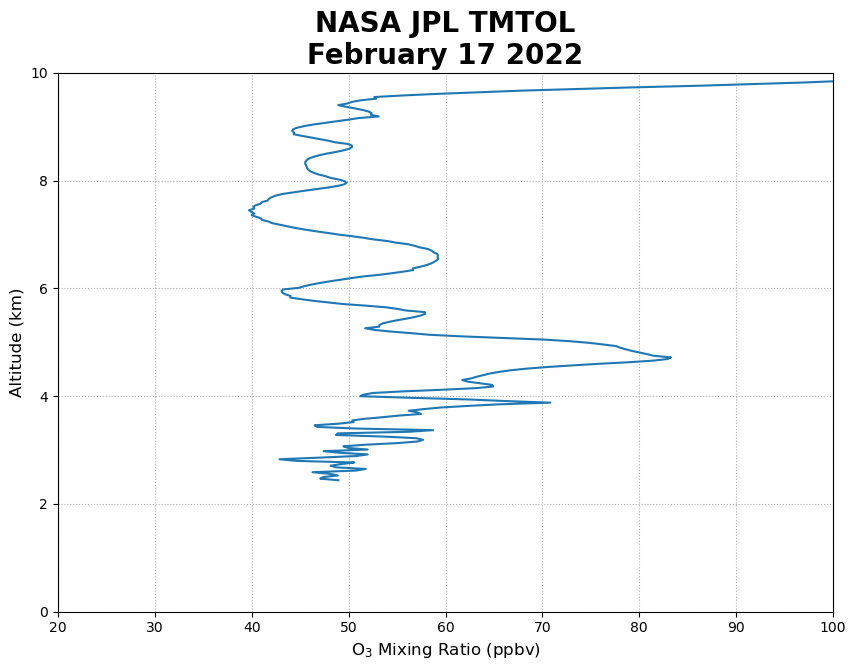

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7), facecolor="white")

plt.plot(o3mr, alt)
plt.xlim([20, 100])
plt.ylim([0, 10])
plt.xlabel("O$_3$ Mixing Ratio (ppbv)", size=12)
plt.ylabel("Altitude (km)", size=12)
plt.title("NASA JPL TMTOL\nFebruary 17 2022", fontweight="bold", size=20)
plt.grid(linestyle=":")

plt.savefig("Plots/NASA-JPL-Lidar_2022-02-17.png")
plt.show()

## NOAA CSL

- You will need to adjust variables based on paths for which file you want to plot

In [12]:
file = "Files/NOAA CSL/groundbased_lidar.o3_noaa.csl001_hires_boulder.co_20220217t153251z_20220217t231251z_001.hdf"
f = SD(file, SDC.READ)

- Read O3 mixing ratio, rotate it so it displays correctly when plotted, and convert from ppmv to ppbv
- Read altitude, convert to km
- Get year fraction from datetime variable, convert it into a useable date and correct timezone

In [ ]:
o3 = f.select("O3.MIXING.RATIO.VOLUME_DERIVED")
o3mr = np.rot90(o3[:, :] * 1000)
wh = np.where(o3mr < 0)
o3mr[wh] = np.nan

alt = f.select("ALTITUDE")
alt = alt[:] / 1000

time = f.select("DATETIME")
time = time[:]
yearfrac = (time / 365.25) % 1
newtime = np.array([])
for i in range(len(yearfrac)):
    newtime = np.append(
        newtime, datetime(2022, 1, 1) + timedelta(yearfrac[i] * 365.25) - timedelta(hours=12)
    )

- Define Min/Max values for the plot, tick values for the time axis
- Create the plot and colorbar

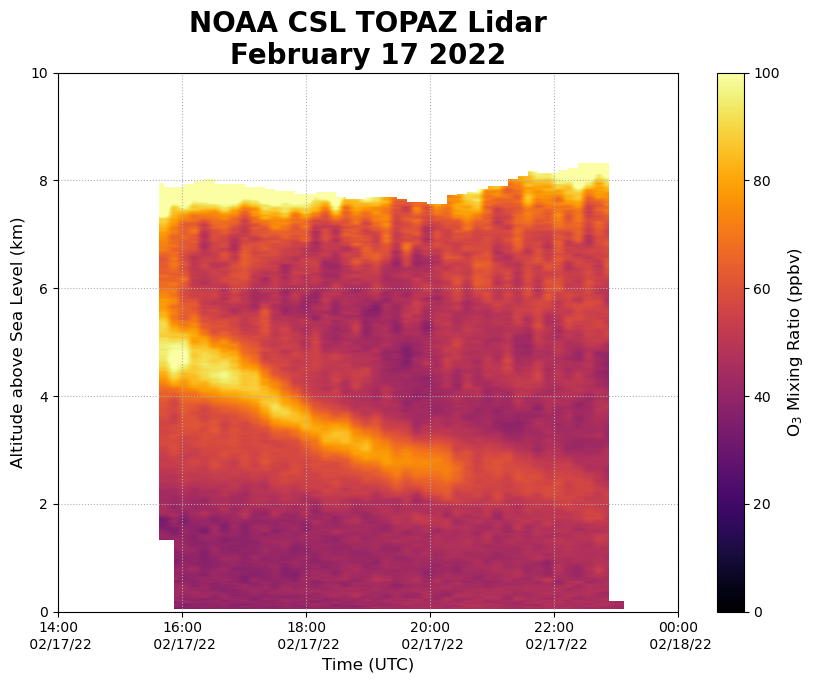

In [ ]:
time_min = mdates.date2num(np.min(newtime))
time_max = mdates.date2num(np.max(newtime))
alt_min = np.min(alt)
alt_max = np.max(alt)

time_ticks = [
    datetime(2022, 2, 17, 14),
    datetime(2022, 2, 17, 16),
    datetime(2022, 2, 17, 18),
    datetime(2022, 2, 17, 20),
    datetime(2022, 2, 17, 22),
    datetime(2022, 2, 18, 0),
]

fig, ax = plt.subplots(figsize=(10, 7), facecolor="white")

uah = ax.imshow(
    o3mr,
    vmin=0,
    vmax=100,
    aspect="auto",
    cmap="inferno",
    extent=(time_min, time_max, alt_min, alt_max),
)
ax.xaxis_date()
date_format = mdates.DateFormatter("%H:%M\n %D")
ax.xaxis.set_major_formatter(date_format)
ax.set(xlabel="Time (UTC)", ylabel="Altitude above Sea Level (km)", xticks=time_ticks)
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)

cbar = plt.colorbar(uah, ax=ax, label="O$_3$ Mixing Ratio (ppbv)")
cbar.set_label("O$_3$ Mixing Ratio (ppbv)", size=12)

plt.title("NOAA CSL TOPAZ Lidar\nFebruary 17 2022", fontweight="bold", fontsize="20")
plt.xlim([datetime(2022, 2, 17, 14), datetime(2022, 2, 18, 0)])
plt.ylim([0, 10])
plt.grid(linestyle=":")

plt.savefig("Plots/NOAA-CSL-Lidar_2022-02-17.png")
plt.show()

## NASA GSFC

Like NASA LaRC, this plot is a combination measurements from two files. This data is currently being reprocessed by John Sullivan.

- You will need to adjust variables based on paths for which file you want to plot

In [4]:
file1 = "Files/NASA GSFC/groundbased_lidar.o3_nasa.gsfc003_hires_la.porte.tx_20220218t000000z_20220219t000000z_001.hdf"
f1 = SD(file1, SDC.READ)

file2 = "Files/NASA GSFC/groundbased_lidar.o3_nasa.gsfc003_hires_la.porte.tx_20220219t000000z_20220220t000000z_001.hdf"
f2 = SD(file2, SDC.READ)

- Read O3 mixing ratio, rotate it so it displays correctly when plotted, and convert from ppmv to ppbv
- Read altitude, convert to km
- Get year fraction from datetime variable, convert it into a useable date and correct timezone

In [ ]:
o3_1 = f1.select("O3.MIXING.RATIO.VOLUME_DERIVED")
o3mr1 = np.rot90(o3_1[:, :] * 1000)

o3_2 = f2.select("O3.MIXING.RATIO.VOLUME_DERIVED")
o3mr2 = np.rot90(o3_2[:, :] * 1000)

alt1 = f1.select("ALTITUDE")
alt1 = alt1[:] / 1000

alt2 = f2.select("ALTITUDE")
alt2 = alt2[:] / 1000

time1 = f1.select("DATETIME")
time1 = time1[:]
yearfrac1 = (time1 / 365.25) % 1
newtime1 = np.array([])
for i in range(len(yearfrac1)):
    newtime1 = np.append(
        newtime1, datetime(2022, 1, 1) + timedelta(yearfrac1[i] * 365.25) - timedelta(hours=12)
    )

time2 = f2.select("DATETIME")
time2 = time2[:]
yearfrac2 = (time2 / 365.25) % 1
newtime2 = np.array([])
for i in range(len(yearfrac2)):
    newtime2 = np.append(
        newtime2, datetime(2022, 1, 1) + timedelta(yearfrac2[i] * 365.25) - timedelta(hours=12)
    )

- Combine data from files into one array
- Set missing data to nan


In [ ]:
o3mr = np.hstack((o3mr1, o3mr2))
time = np.append(newtime1, newtime2)
alt = np.append(alt1, alt2)

wh = np.where(o3mr <= 0)
o3mr[wh] = np.nan

- Define Min/Max values for the plot, tick values for the time axis
- Create the plot and colorbar

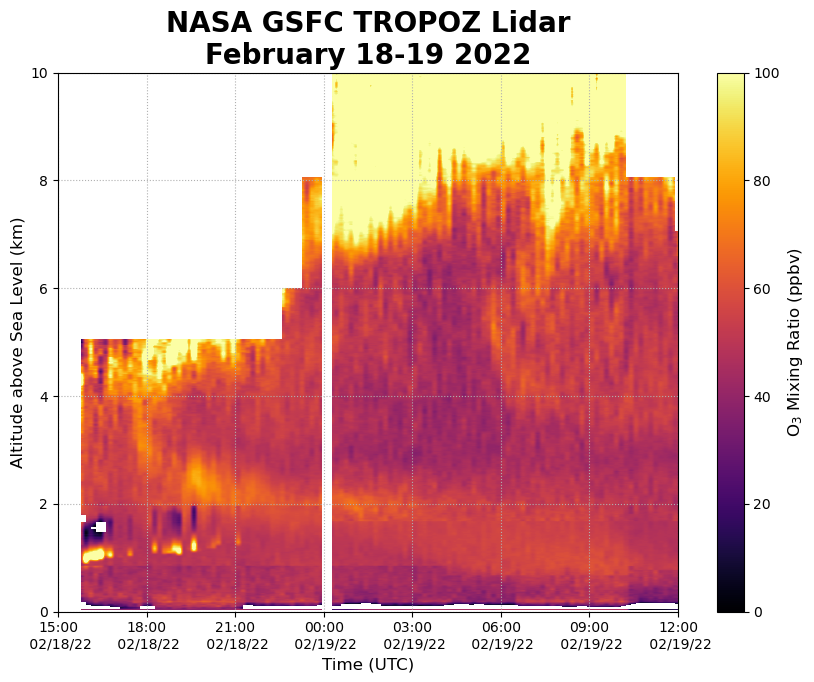

In [ ]:
time_min = mdates.date2num(np.min(time))
time_max = mdates.date2num(np.max(time))
alt_min = np.min(alt)
alt_max = np.max(alt)

time_ticks = [
    datetime(2022, 2, 18, 15),
    datetime(2022, 2, 18, 18),
    datetime(2022, 2, 18, 21),
    datetime(2022, 2, 19, 0),
    datetime(2022, 2, 19, 3),
    datetime(2022, 2, 19, 6),
    datetime(2022, 2, 19, 9),
    datetime(2022, 2, 19, 12),
]

fig, ax = plt.subplots(figsize=(10, 7), facecolor="white")

gsfc = ax.imshow(
    o3mr,
    vmin=0,
    vmax=100,
    aspect="auto",
    cmap="inferno",
    extent=(time_min, time_max, alt_min, alt_max),
)
ax.xaxis_date()
date_format = mdates.DateFormatter("%H:%M\n %D")
ax.xaxis.set_major_formatter(date_format)
ax.set(xlabel="Time (UTC)", ylabel="Altitude above Sea Level (km)", xticks=time_ticks)
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)

cbar = plt.colorbar(gsfc, ax=ax, label="O$_3$ Mixing Ratio (ppbv)")
cbar.set_label("O$_3$ Mixing Ratio (ppbv)", size=12)

plt.title("NASA GSFC TROPOZ Lidar\nFebruary 18-19 2022", fontweight="bold", fontsize="20")
plt.xlim([datetime(2022, 2, 18, 15), datetime(2022, 2, 19, 12)])
plt.ylim([0, 10])
plt.grid(linestyle=":")

plt.savefig("Plots/NASA-GSFC-Lidar_2022-02-18.png")
plt.show()